In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [2]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants


from triage.component.catwalk.storage import ProjectStorage

In [4]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)

#### Fetching the available labels

In [62]:
# assuming that every label has a labeler associated with it

q = """
    SELECT 
        * 
    FROM aclu_labels.issue_areas 
    where labeler is not null
"""

all_labels = pd.read_sql(q, db_conn)
all_labels.shape

(200, 11)

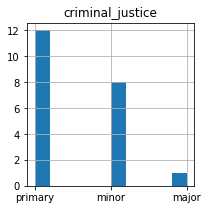

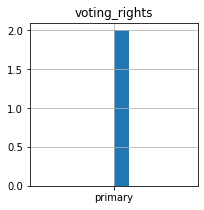

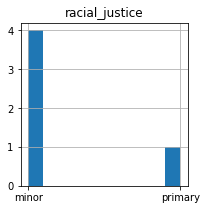

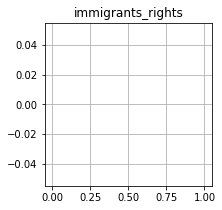

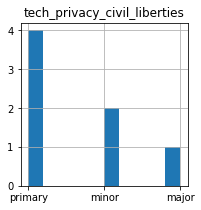

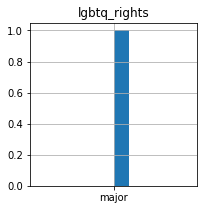

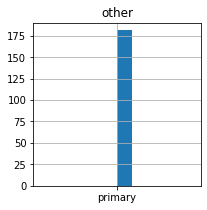

In [63]:
for issue_area in constants.ISSUE_AREAS:
    fig, ax = plt.subplots(figsize=(3,3))
    all_labels[issue_area].hist(label=issue_area, ax=ax)
    ax.set_title(issue_area)

##### "other" issue area

In [59]:
q = """
    SELECT * FROM aclu_labels.issue_areas where other = 'primary'
"""

other_bill_docs = pd.read_sql(q, db_conn)

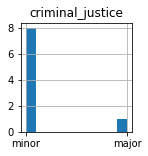

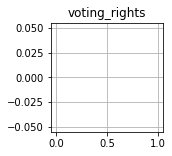

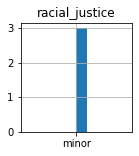

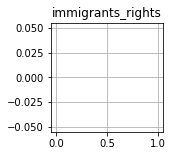

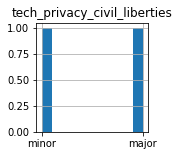

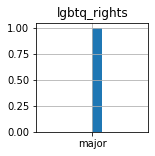

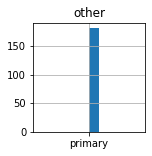

In [61]:
for issue_area in constants.ISSUE_AREAS:
    fig, ax = plt.subplots(figsize=(2,2))
    other_bill_docs[issue_area].hist(label=issue_area, ax=ax)
    ax.set_title(issue_area)

#### How the bills are distributed across time and States

In [64]:
q = """
    with bils_labeled as (
        select 
            * 
        from aclu_labels.issue_areas where labeler is not null
    )
    select 
        doc_id,
        doc_date,
        bill_type,
        extract(year from doc_date) as doc_year,
        bill_id,
        introduced_date,
        extract(year from introduced_date) as bill_year,
        state,
        labeler,
        criminal_justice,
        voting_rights,
        racial_justice,
        immigrants_rights,
        tech_privacy_civil_liberties,
        lgbtq_rights,
        other
    from bils_labeled join clean.bill_docs using (doc_id)
        join clean.bills using(bill_id)
"""

labeled_bill_details = pd.read_sql(q, db_conn)

#### States

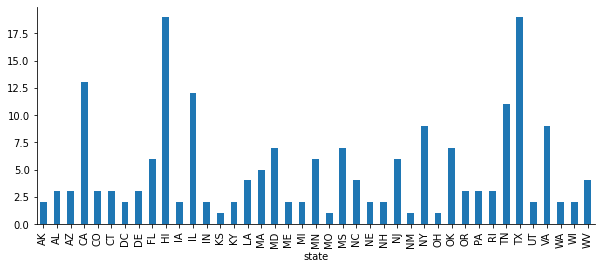

In [65]:
fig, ax = plt.subplots(figsize=(10,4))
labeled_bill_details.groupby('state').count()['doc_id'].plot(kind='bar')
sns.despine()

#### Bill type

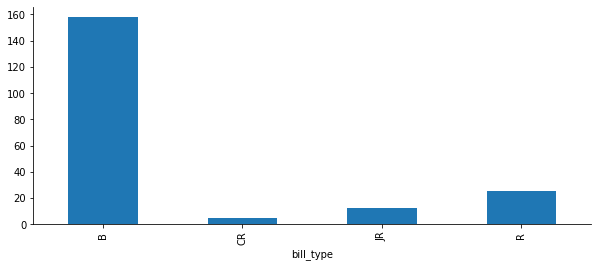

In [67]:
fig, ax = plt.subplots(figsize=(10,4))
labeled_bill_details.groupby('bill_type').count()['doc_id'].plot(kind='bar')
sns.despine()

#### Time

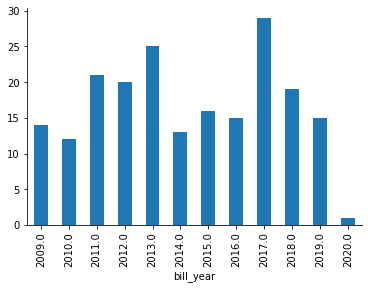

In [66]:
fig, ax = plt.subplots(figsize=(6,4))
labeled_bill_details.groupby('bill_year').count()['doc_id'].plot(kind='bar')
sns.despine()

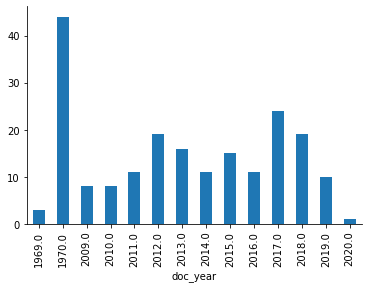

In [58]:
fig, ax = plt.subplots(figsize=(6,4))
labeled_bill_details.groupby('doc_year').count()['doc_id'].plot(kind='bar')
sns.despine()

#### Next steps

1. start training very simple text models (Binary classifier, linear model with bag-of-words features)
    - figure out how to reconsile the three levels of labels. We can start with "primary" & "major" as a 1 for now?
    - We have a bunch of bills that are labeled from CA (~4000). But we don't know which bill version the label applies to, and it's not in the granularity that we want. We can assume that they are "primary" or "major" focuses of a bill and use it as a "1". Plus, we could randomly sample the bill_doc from those bills and assign the label to that for now
2. Generate predictions for samples of other bills and iteratively send out those bills to ACLU for labeling. This can serve as a validation of the models as well as training data for improving the models
3. Label the 100 bills
4. Get the conversation with the affiliates started back up again for a potential trial